In [1]:
from pathlib import Path
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gym_recording_modified.playback import get_recordings
from utils.data_extractors import *
from utils.visualizations import *
import seaborn as sns
from scipy.stats import sem
from scipy.signal import convolve2d

In [2]:
root = Path('results_new_sweep')
filters = {
    'buffer_size' : [10000],
    'env': ['envs:random_maze-v0', 'CartPole-v1']}

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)

16200it [05:25, 49.74it/s]


In [3]:
df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df = pd.concat([df1, df2], axis=1)
df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df = df.drop(['Seed'],axis=1)
df['Algorithm'] = df['Model'] + ', ' + df['L'] 
df = df.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df = df.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df = df.replace('FFN, 10', 'DQN')
df = df.replace('FFN, 1', 'DQN')

df = df.replace('RNN, 1', 'DRQN, 1')
df = df.replace('RNN, 2', 'DRQN, 2')
df = df.replace('RNN, 4', 'DRQN, 4')
df = df.replace('RNN, 8', 'DRQN, 8')


In [4]:
df_mean = df.groupby(columns).mean().reset_index() # dataframe with mean over seeds for each parameter/alg/env configuration

# Total Number of episodes completed for all hyperparameters

In [55]:
colours = sns.color_palette()
c_dict = {}
algs = df_mean.Algorithm.unique()
for alg in algs:
    c_dict[alg] = colours.pop(0)
c_dict

{'DQN': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'DRQN, 1': (1.0, 0.4980392156862745, 0.054901960784313725),
 'DRQN, 2': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'DRQN, 4': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'DRQN, 8': (0.5803921568627451, 0.403921568627451, 0.7411764705882353)}

In [70]:
# Box plots of average number of episodes completed for all algorithms


for env in df_mean.Env.unique():

    g = sns.boxplot(x='Algorithm', y='Num Episodes',  data=df_mean.loc[df_mean['Env']==env])
    g.set_ylabel("Number of Episodes Completed")
    for i in range(0,5):
        mybox = g.artists[i]
        mybox.set_facecolor(c_dict[algs[i]])
    g.set_xlabel("")
    g.set_xticklabels(g.get_xticklabels(),rotation=30)
    #g.set_xticklabels(rotation=30)
    plt.savefig('figures/hyper_param_sensitivity_%s.pdf'%env, bbox_inches='tight')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [6]:
def n_best_params(df, env, alg, n, columns, metric, maximize=True):
    '''
    returns the n best hyperparameter of alg on env accroding to metric column in df
    if maximize = True then higher numbers are better
    '''
    df_env_alg = df.loc[(df['Env'] == env) & (df['Algorithm'] ==alg)] # filtered by env and alg
    if maximize:
        df_env_alg = df_env_alg.nlargest(n, metric)
    else:
        df_env_alg = df_env_alg.nsmallest(n, metric)

    df_env_alg = df_env_alg.set_index(columns)
    inds = df_env_alg.index.tolist()

    return inds

In [7]:
def get_best_data(df, df_mean, columns, metric):
    '''
    Filters a dataframe to only include data from the best hyperparameters, as determined by df_mean
    '''
    inds = []
    for env in df['Env'].unique():
        for alg in df['Algorithm'].unique():
            if env == 'CartPole-v1': # fewer episodes completed is better for cartpole
                maximize = False
            else:
                maximize = True

            inds += n_best_params(df_mean, env, alg, 1, columns, metric, maximize=maximize)
    
    df_ = df.set_index(columns)
    df_ = df_.loc[inds]
    return df_.reset_index(), inds

## Total Number of episodes completed for best hyperparameters

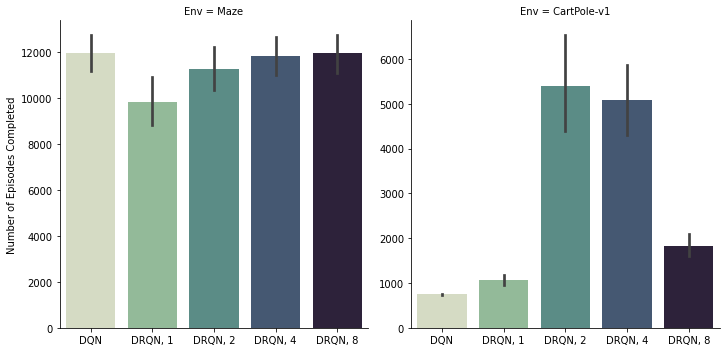

In [8]:
df_best, best_inds = get_best_data(df, df_mean, columns, 'Num Episodes')

for env in df_best.Env.unique():

    g = sns.barplot(x='Algorithm', y='Num Episodes', col='Env', data=df_best, kind='bar', ci=68, sharey=False)
    g.set_ylabel("Number of Episodes Completed")
    plt.savefig('figures/total_episodes_best_params.pdf', bbox_inches='tight')

## average episode length for best hyperparameters last 50 episodes

In [10]:
root = Path('results_best')
filters = None

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, episode_len = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs, last_n=30)

avg = np.zeros(episode_len.shape[0])
for i in range(episode_len.shape[0]):
    avg[i] = np.mean(episode_len[i])

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(avg)
df_last = pd.concat([df1, df2], axis=1)
df_last.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Average Episode Length']
df_last = df_last.drop(['Seed'],axis=1)
df_last['Algorithm'] = df_last['Model'] + ', ' + df_last['L'] 
df_last = df_last.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_last = df_last.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_last = df_last.replace('FFN, 10', 'DQN')
df_last = df_last.replace('FFN, 1', 'DQN')

df_last = df_last.replace('RNN, 1', 'DRQN, 1')
df_last = df_last.replace('RNN, 2', 'DRQN, 2')
df_last = df_last.replace('RNN, 4', 'DRQN, 4')
df_last = df_last.replace('RNN, 8', 'DRQN, 8')


1000it [00:08, 121.70it/s]


In [12]:
root = Path('results_best')
filters = None

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)


df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df_best = pd.concat([df1, df2], axis=1)
df_best.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df_best = df_best.drop(['Seed'],axis=1)
df_best['Algorithm'] = df_best['Model'] + ', ' + df_best['L'] 
df_best = df_best.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_best = df_best.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_best = df_best.replace('FFN, 10', 'DQN')
df_best = df_best.replace('FFN, 1', 'DQN')

df_best = df_best.replace('RNN, 1', 'DRQN, 1')
df_best = df_best.replace('RNN, 2', 'DRQN, 2')
df_best = df_best.replace('RNN, 4', 'DRQN, 4')
df_best = df_best.replace('RNN, 8', 'DRQN, 8')

1000it [00:00, 1814.47it/s]


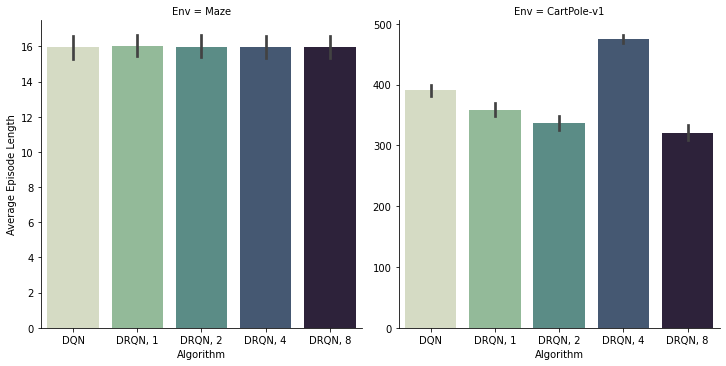

In [13]:

g = sns.catplot(x='Algorithm', y='Average Episode Length', col='Env', data=df_last, kind='bar', ci=68,  sharey=False, palette= sns.cubehelix_palette(5, start=.5, rot=-.75))
plt.savefig('figures/last_50_length_best_params.pdf', bbox_inches='tight')

In [14]:
df_temp = pd.concat([df_last.set_index(columns), df_best.set_index(columns)], axis=1)
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['Learning Freq.', 'Target Update Freq.',  'Step Size', 'Buffer Size'], axis=1)
df_temp = df_temp.melt(id_vars=['Algorithm', 'Env'], var_name = 'source', value_name='val')

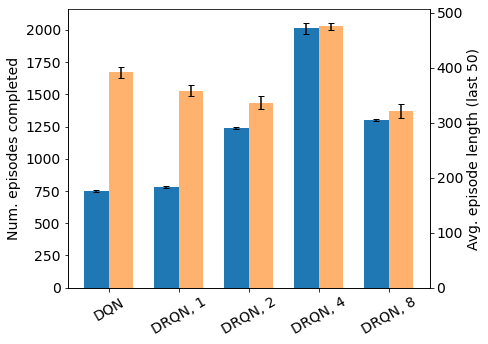

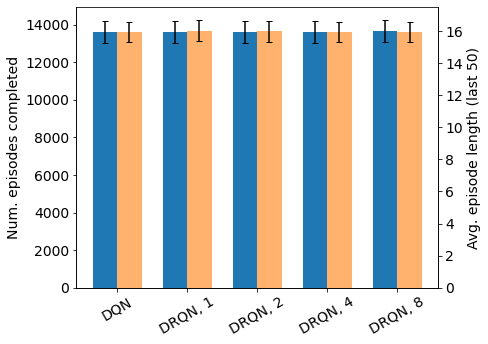

In [63]:
# double bar plot

font = {'size'   : 16}

matplotlib.rc('font', **font)
env_ind = 1

data = df_temp.values
algs =  np.unique(data[:, 0])
envs = np.unique(data[:, 1])

x = np.arange(len(algs))  # the label locations
width = 0.35  # the width of the bars

ax_idx = 0

sns.color_palette().as_hex()

for env in envs:
    num_subplots = envs.shape[0]
    fig, ax = plt.subplots(1, 1, figsize=(7,5))
    #ax = axs[0]
    data_num_episodes_to_plot = []
    data_ep_len_to_plot = []
    num_episodes_err = []
    ep_len_err = []
    scale = 1

    for alg in algs:
        data_num_episodes = data[np.where((data[:, 2] == 'Num Episodes') & (data[:, 1] ==env) & (data[:, 0] == alg))]
        data_ep_len = data[np.where((data[:, 2] == 'Average Episode Length') & (data[:, 1] ==env) & (data[:, 0] == alg))]       

        data_num_episodes_to_plot.append(np.mean(data_num_episodes[:, 3]))
        data_ep_len_to_plot.append(np.mean(data_ep_len[:, 3]* scale ))
        num_episodes_err.append(sem(data_num_episodes[:, 3]))
        ep_len_err.append(sem(data_ep_len[:, 3]))

    rects1 = ax.bar(x - width/2, data_num_episodes_to_plot, width, label='Overall Performance', color='tab:blue' )
    ax.errorbar(x - width/2, data_num_episodes_to_plot, yerr=num_episodes_err, ecolor='black', capsize=3, ls='none' )

    ax.set_ylabel('Num. episodes completed')
    #ax.set_title(env)
    ax.set_xticks(x)
    ax.set_xticklabels(algs, rotation=30)
    ax2 = ax.twinx()
    ax2.set_ylabel('Avg. episode length (last 50)')

    rects2 = ax2.bar(x + width/2, data_ep_len_to_plot, width, label='Final Performance', color='tab:orange', alpha = 0.6)
    ax2.errorbar(x + width/2, data_ep_len_to_plot, yerr=ep_len_err, ecolor='black', capsize=3, ls='none' )

    handles, labels = ax.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center')
    plt.xticks(rotation=290)
    fig.gca().spines['top'].set_visible(False)
    fig.tight_layout()
    plt.savefig("figures/double_bar%s.pdf"%env, bbox_inches='tight')

In [38]:
root = Path('results_best')
filters = {
    'buffer_size' : [10000],
    'env': ['envs:random_maze-v0', 'CartPole-v1']}

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, ep_lens = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)
df1 = pd.DataFrame(params)
df2 = pd.DataFrame(ep_lens)

df = pd.concat([df1, df2], axis=1)
df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Episode Lengths']
df = df.drop(['Seed'],axis=1)
df['Algorithm'] = df['Model'] + ', ' + df['L'] 
df = df.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df = df.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df = df.replace('FFN, 10', 'DQN')
df = df.replace('FFN, 1', 'DQN')

df = df.replace('RNN, 1', 'DRQN, 1')
df = df.replace('RNN, 2', 'DRQN, 2')
df = df.replace('RNN, 4', 'DRQN, 4')
df = df.replace('RNN, 8', 'DRQN, 8')

1000it [00:05, 175.21it/s]
                                                     0
0    [856, 548, 1911, 248, 762, 447, 466, 107, 453,...
1    [2988, 200, 602, 1200, 1214, 977, 382, 498, 18...
2    [264, 834, 2945, 486, 482, 619, 601, 279, 380,...
3    [524, 1183, 960, 318, 687, 511, 305, 315, 120,...
4    [2523, 1476, 1665, 521, 363, 151, 613, 959, 48...
..                                                 ...
995  [33, 11, 24, 25, 10, 12, 10, 12, 22, 31, 16, 2...
996  [41, 23, 13, 17, 11, 11, 17, 12, 46, 36, 14, 2...
997  [14, 27, 13, 14, 12, 31, 24, 14, 13, 17, 37, 2...
998  [55, 15, 19, 36, 40, 12, 48, 32, 18, 30, 16, 1...
999  [13, 35, 25, 11, 21, 28, 29, 16, 14, 13, 13, 1...

[1000 rows x 1 columns]


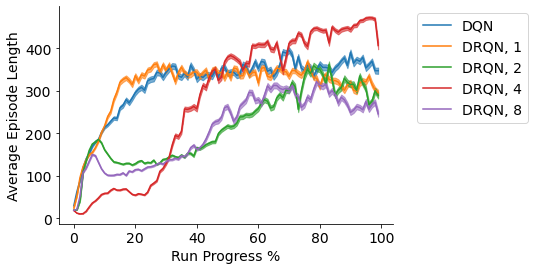

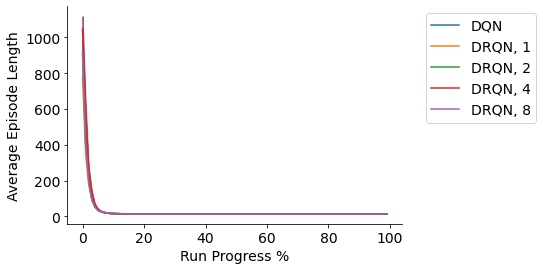

In [64]:
'''
Bins episode lengths in each run into 100 bins and then creates learning curves,
averaging across the corresponding bins for all 100 runs of the best parameter settings
'''    


envs = ['CartPole-v1', 'Maze']
for env in envs:
    algs = []
    plt.figure()
    ax = plt.gca()
    for alg in df.Algorithm.unique():
        algs.append(alg)
        df_DRQN4 = df.loc[(df['Env'] == env) & (df['Algorithm'] == alg)]
        data = df_DRQN4['Episode Lengths'].values
        n_bins = 100
        bin_size = 200000/n_bins
        bins = [[] for i in range(n_bins)]

        for run in data:
            sum_ = 0
            for i, ep_len in enumerate(run):
                ind = int(sum_ // bin_size)  # which bin to place data (based on start time)
                bins[ind].append(ep_len)
                sum_ += ep_len 

        mean = np.array([ np.sum(i)/len(i) for i in bins])
        sigma = np.array([np.std(i,axis=0)/np.sqrt(len(i)) for i in bins])
        t = np.linspace(0, n_bins-1, n_bins)
        plt.plot(mean, color=c_dict[alg])
        ax.fill_between(t, mean+sigma, mean-sigma, alpha=0.6, color=c_dict[alg])

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Run Progress %')
    plt.ylabel('Average Episode Length')
    plt.legend(algs, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('figures/learning_curve_best_%s.pdf'%env, bbox_inches='tight')